In [1]:
# First import necessary libraries
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import time
import os

In [2]:
# Define basic parameters
S0 = 100.0  # Initial price of the underlying asset
K = 100.0   # Strike price
T_annual = 1.0  # Option maturity (years)
U_annual = 0.5  # Choice period (years), range 0-1
r_annual = 0.05 # Annual risk-free interest rate
sigma = 0.20    # Volatility of the underlying asset

In [3]:
# 1. Define BSM option pricing function
def bsm_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the BSM (Black-Scholes-Merton) price of a European option
    
    Parameters:
    S: Price of the underlying asset
    K: Strike price of the option
    T: Time to maturity (in years)
    r: Risk-free interest rate (annualized)
    sigma: Volatility of the underlying asset (annualized)
    option_type: Type of option, 'call' for call option, 'put' for put option
    
    Returns:
    Calculated price of the European option
    """
    if T == 0:  # Option price at maturity (no time value left)
        return max(0, S - K) if option_type == 'call' else max(0, K - S)
    # Calculate d1 and d2 (core parameters in BSM model)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Calculate price based on option type
    if option_type == 'call':
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    return price

# Test the BSM function with initial parameters
call_price = bsm_price(S0, K, T_annual, r_annual, sigma, 'call')
put_price = bsm_price(S0, K, T_annual, r_annual, sigma, 'put')
print(f"BSM Call Option Price: {call_price:.5f}")
print(f"BSM Put Option Price: {put_price:.5f}")

BSM Call Option Price: 10.45058
BSM Put Option Price: 5.57353


In [4]:
# 2. Define function for analytical price of Chooser option
def chooser_price_analytical(S0, K, T_annual, U_annual, r_annual, sigma):
    """
    Calculate the analytical price of a Chooser option
    
    Parameters:
    S0: Initial price of the underlying asset
    K: Strike price of the option
    T_annual: Total time to maturity of the Chooser option (years)
    U_annual: Time to choice date (years) – when holder decides option type
    r_annual: Annualized risk-free interest rate
    sigma: Annualized volatility of the underlying asset
    
    Returns:
    Analytical price of the Chooser option
    """
    # Adjusted strike price for the put component (present value of K)
    K_prime = K * np.exp(-r_annual * (T_annual - U_annual))
    # Call option maturing at T (full maturity)
    call_T = bsm_price(S0, K, T_annual, r_annual, sigma, 'call')
    # Put option maturing at U (choice date) with adjusted strike K_prime
    put_U = bsm_price(S0, K_prime, U_annual, r_annual, sigma, 'put')
    # Chooser price = call_T + put_U (derived from option parity)
    return call_T + put_U

# Test the Chooser option analytical function
analytical_price = chooser_price_analytical(S0, K, T_annual, U_annual, r_annual, sigma)
print(f"Chooser Option Analytical Price: {analytical_price:.5f}")

Chooser Option Analytical Price: 13.85133


In [5]:
# 3. Define function for Chooser option pricing using Binomial Tree model
def chooser_pricer_binomial(n, S0, K, T_annual, U_annual, r_annual, sigma):
    """
    Calculate the price of a Chooser option using the Binomial Tree model
    
    Parameters:
    n: Number of time steps in the binomial tree
    S0: Initial price of the underlying asset
    K: Strike price of the option
    T_annual: Total time to maturity (years)
    U_annual: Time to choice date (years)
    r_annual: Annualized risk-free interest rate
    sigma: Annualized volatility of the underlying asset
    
    Returns:
    Calculated price of the Chooser option from the binomial tree
    """
    dt = T_annual / n  # Time increment per step (Δt)
    u = np.exp(sigma * np.sqrt(dt))  # Up-move factor for underlying price
    d = 1 / u  # Down-move factor for underlying price (inverse of up factor)
    r_factor = np.exp(r_annual * dt)  # Discount factor per step (present value adjustment)
    q = (r_factor - d) / (u - d)  # Risk-neutral probability of up-move
    U_step = int(U_annual / dt)  # Number of steps corresponding to the choice date

    # Step 1: Build the underlying asset price tree
    stock_tree = np.zeros((n + 1, n + 1))  # (i, t) where i=down steps, t=total steps
    for t in range(n + 1):
        for i in range(t + 1):
            # Price = Initial price * (up factor)^(up steps) * (down factor)^(down steps)
            stock_tree[i, t] = S0 * (u ** (t - i)) * (d ** i)

    # Step 2: Build call and put option trees (backward induction from maturity)
    call_tree = np.zeros((n + 1, n + 1))  # Tree for call option values
    put_tree = np.zeros((n + 1, n + 1))   # Tree for put option values
    
    # Option values at maturity (only intrinsic value remains)
    for i in range(n + 1):
        call_tree[i, n] = max(0, stock_tree[i, n] - K)  # Intrinsic value of call
        put_tree[i, n] = max(0, K - stock_tree[i, n])   # Intrinsic value of put
    
    # Backward induction from maturity to choice date (U_step)
    for t in range(n - 1, U_step - 1, -1):
        for i in range(t + 1):
            # Discount expected future value to current step (risk-neutral valuation)
            call_tree[i, t] = (q * call_tree[i, t + 1] + (1 - q) * call_tree[i + 1, t + 1]) / r_factor
            put_tree[i, t] = (q * put_tree[i, t + 1] + (1 - q) * put_tree[i + 1, t + 1]) / r_factor

    # Step 3: Build Chooser option tree (backward from choice date to t=0)
    chooser_tree = np.zeros((n + 1, n + 1))  # Tree for Chooser option values
    
    # At choice date: holder selects more valuable option (call or put)
    for i in range(U_step + 1):
        chooser_tree[i, U_step] = max(call_tree[i, U_step], put_tree[i, U_step])
    
    # Backward induction from choice date to initial time (t=0)
    for t in range(U_step - 1, -1, -1):
        for i in range(t + 1):
            # Discount expected future Chooser value to current step
            chooser_tree[i, t] = (q * chooser_tree[i, t + 1] + (1 - q) * chooser_tree[i + 1, t + 1]) / r_factor
    
    # Return initial price (top-left node of the Chooser tree)
    return chooser_tree[0, 0]

# Test the binomial tree function (with small step count for efficiency)
test_steps = 10
binomial_test_price = chooser_pricer_binomial(test_steps, S0, K, T_annual, U_annual, r_annual, sigma)
print(f"{test_steps}-step Binomial Tree Chooser Option Price: {binomial_test_price:.5f}")

10-step Binomial Tree Chooser Option Price: 13.84530


In [6]:
# 4. Compare binomial tree prices with analytical solution across step counts
n_range = list(range(10, 201, 10)) + list(range(250, 1001, 50))  # Step counts to test
binomial_prices = []  # Store binomial prices for each step count

# Calculate analytical solution and measure computation time
start_time = time.time()
analytical_price = chooser_price_analytical(S0, K, T_annual, U_annual, r_annual, sigma)
end_time = time.time()
print(f"BSM Analytical Solution (Theoretical Value): {analytical_price:.5f} (Computation Time: {end_time - start_time:.4f}s)")
print("-" * 75)
# Print comparison table header
print(f"{'Steps (n)':<12} | {'Binomial Price':<18} | {'BSM Theoretical Value':<25} | {'Absolute Error':<15}")
print("-" * 75)

# Calculate binomial price for each step count and compare
for n in n_range:
    start_time = time.time()
    binomial_price = chooser_pricer_binomial(n, S0, K, T_annual, U_annual, r_annual, sigma)
    end_time = time.time()
    binomial_prices.append(binomial_price)
    absolute_error = abs(binomial_price - analytical_price)
    # Print row with step count, price, theoretical value, error, and computation time
    print(f"{n:<12} | {binomial_price:<18.5f} | {analytical_price:<25.5f} | {absolute_error:<15.5f} (Time: {end_time - start_time:.4f}s)")

BSM Analytical Solution (Theoretical Value): 13.85133 (Computation Time: 0.0012s)
---------------------------------------------------------------------------
Steps (n)    | Binomial Price     | BSM Theoretical Value     | Absolute Error 
---------------------------------------------------------------------------
10           | 13.84530           | 13.85133                  | 0.00603         (Time: 0.0002s)
20           | 13.82167           | 13.85133                  | 0.02966         (Time: 0.0005s)
30           | 13.79226           | 13.85133                  | 0.05907         (Time: 0.0011s)
40           | 13.85776           | 13.85133                  | 0.00643         (Time: 0.0018s)
50           | 13.78233           | 13.85133                  | 0.06900         (Time: 0.0035s)
60           | 13.86002           | 13.85133                  | 0.00869         (Time: 0.0047s)
70           | 13.79161           | 13.85133                  | 0.05972         (Time: 0.0063s)
80           |

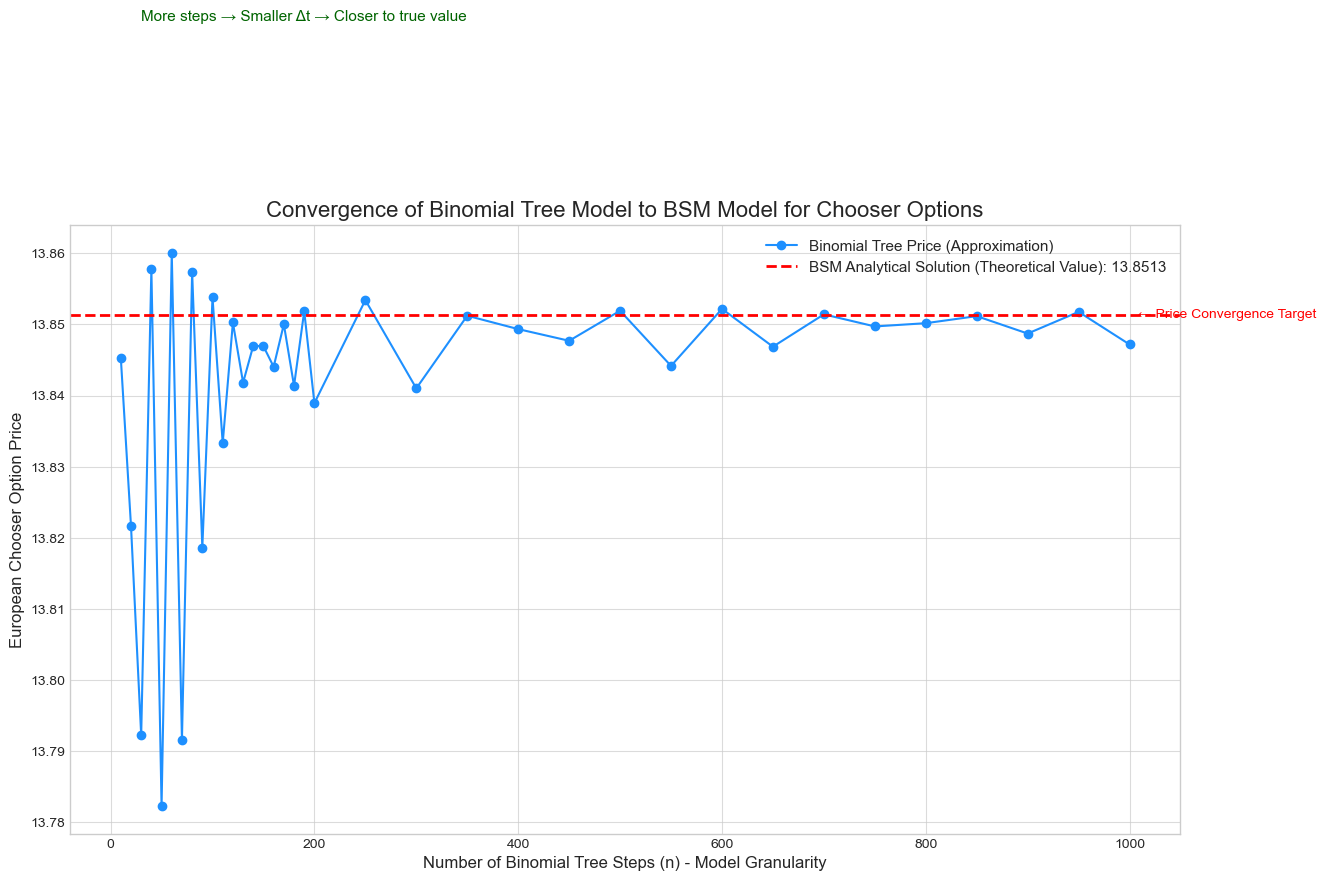

Plot saved to: /Users/cypresscai/Desktop/our_python_project/Chooser_Option_Pricing_Model-0.1.0/figures/chooser_with_deltat_plots.png


In [7]:
# 5. Plot convergence of binomial tree to BSM analytical solution
plt.style.use('seaborn-v0_8-whitegrid')  # Set plot style for readability
plt.figure(figsize=(12, 7))  # Set figure size

# Plot binomial tree prices (approximation)
plt.plot(n_range, binomial_prices, marker='o', linestyle='-', color='dodgerblue',
         label='Binomial Tree Price (Approximation)')

# Plot BSM analytical solution (theoretical benchmark)
plt.axhline(y=analytical_price, color='red', linestyle='--', linewidth=2,
            label=f'BSM Analytical Solution (Theoretical Value): {analytical_price:.4f}')

# Add plot title and axis labels
plt.title('Convergence of Binomial Tree Model to BSM Model for Chooser Options', fontsize=16)
plt.xlabel('Number of Binomial Tree Steps (n) - Model Granularity', fontsize=12)
plt.ylabel('European Chooser Option Price', fontsize=12)

# Add legend and grid
plt.legend(fontsize=11)
plt.grid(True, alpha=0.7)  # Alpha adjusts grid transparency
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Add explanatory text annotations
plt.text(n_range[-1], analytical_price, '  ← Price Convergence Target', 
         color='red', va='center', ha='left', fontsize=10)
plt.text(n_range[2], binomial_prices[2] + 0.1, 'More steps → Smaller Δt → Closer to true value', 
         color='darkgreen', va='bottom', ha='left', fontsize=11)

# Save plot to a "figures" directory (create if it doesn't exist)
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)  # Avoid error if directory already exists
plt.savefig(os.path.join(out_dir, "chooser_with_deltat_plots.png"), dpi=200)  # High DPI for clarity
plt.show()  # Display the plot

# Print confirmation of save location
print(f"Plot saved to: {os.path.join(out_dir, 'chooser_with_deltat_plots.png')}")